In [1]:
import numpy as np
from helpers import *
from analytical_approaches import bernardes_eq, markov_approach, including_fusion

import networkx as nx

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from ShortestPath.shortest_path import monte_carlo

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns

In [2]:
#Constants
vertices = 8
sim_count = 10000

So the grid would look like,

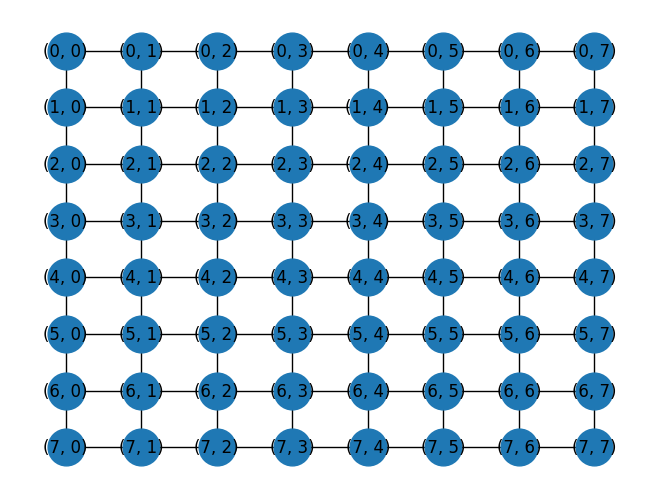

In [3]:
G = nx.grid_2d_graph(vertices, vertices)
pos = {(x, y): (y, -x) for x, y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=700)

##### Non-deterministic p

We begin our analysis by looking at the current literature available on this topic. The most revelant paper is by Brand et al, 2019 which delivers a Monte Carlo method to simulate the swapping on a bipartitie chain. They state that this is concurrent with the work of Shchukin et al, 2017 which in turn is concurrent with the work of Bernades et al, 2009. Therefore, we begin our analysis by verifying the Monte-Carlo simulation provided by Brand against Shchukin and Bernades.

We start our analysis by first comparing their work to the work of Bernades et al.

To verify against the equation presented by Bernades et al, 

$$
Z_n(P) = \sum^{2^n}_{j = 1} \binom{2^n}{j} \frac{(-1)^{j+1}}{1 - (1 - P)^j}
$$

where $P$ is the probability of successfully displaying an outcome, and $n$ is the number of times the event has occured, we need to find a way to calculate this value ($n$) for our use case. Our use case is the grid topology and the value $n$ is the number of segments. Due to the parallel execution of the instruction of attempting to generate entanglement in the links (our event), $n$ is the max number of segments in a branch. From the intuition and knowledge of Dijkstra's path finding algorithm, the shortest path is the Manhattan distance from the user to the central node. This allows us to write the following,

$$

N_{ours} = MD(\textrm{user}, \textrm{central node}) = \max \left[(\textrm{user}[x] - \textrm{central node}[x]) + (\textrm{user}[y] - \textrm{central node}[y]) \right] \textrm{ }\forall\textrm{ } \set{\textrm{users}}.

$$

where $MD$ is the Manhattan distance, $[x]$ & $[y]$ are the x and y coordinates.

In [4]:
p = 0.1; q = 1; k = 1
bernades = bernardes_eq(manhattan_distance(vertices), p)
mc = monte_carlo(vertices, sim_count, sim_count, p, 1, 1)

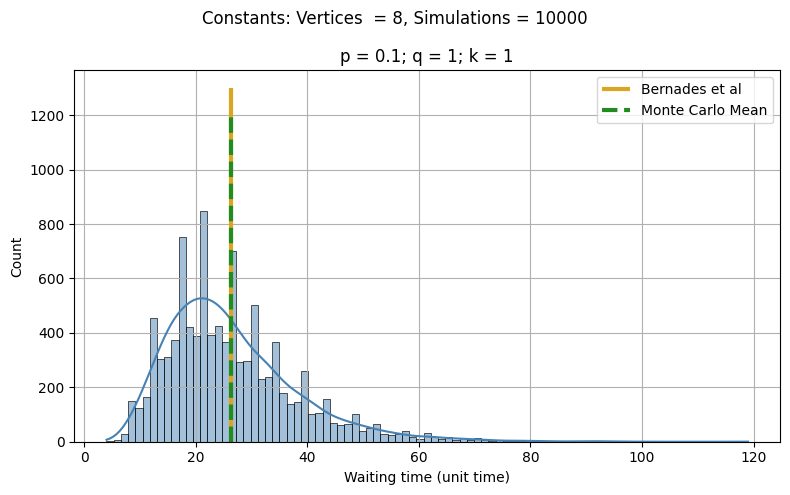

In [5]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.histplot(mc, ax = ax, kde = True, color = 'steelblue')
ax.vlines(bernades, 0, 1300, colors='goldenrod', label = 'Bernades et al', linewidth = 3)
ax.vlines(np.mean(mc), 0, 1200, colors='forestgreen', label = 'Monte Carlo Mean', linewidth = 3, linestyle = "dashed")
ax.set_xlabel("Waiting time (unit time)")
ax.set_ylabel("Count")
ax.set_title(f"p = {p}; q = {q}; k = {k}")
ax.legend(loc = 'best')
ax.grid(True)


plt.suptitle(f"Constants: Vertices  = {vertices}, Simulations = {sim_count}")

plt.tight_layout()

We clearly see that the Monte-Carlo simulation provided by Brand works well with non-deterministic $p$.

##### Non-deterministic p & q

In the Brand paper, he works with the number of nesting levels as the input variable with each nesting level having alternating swaps. For example in a 3 repeater chain, meaning that we have 4 segments to swap over, the nesting levels work by first attempting swapping over the first and third repeater, and finally at the second; giving us 2 nesting levels for a 4 segment chain. This introduces the $2^n$ scaling of this model. Therefore, for the sake of our initial analysis (before moving into a regime where $n \mod(2) \neq 0$ for any number of segments, n), we will work with values like 2, 4, 8, 16.

Given that our vertices count is 8, we can consider 3 nesting levels.

The ``monte_carlo_brand`` considers this and translates from vertices to nesting levels via the ``good_factors`` function.

In [6]:
p = 0.1
q = 0.9
k = 1

mc = monte_carlo(vertices, sim_count, sim_count, p, q, k)

shchukin_vals = markov_approach(vertices, p, q)

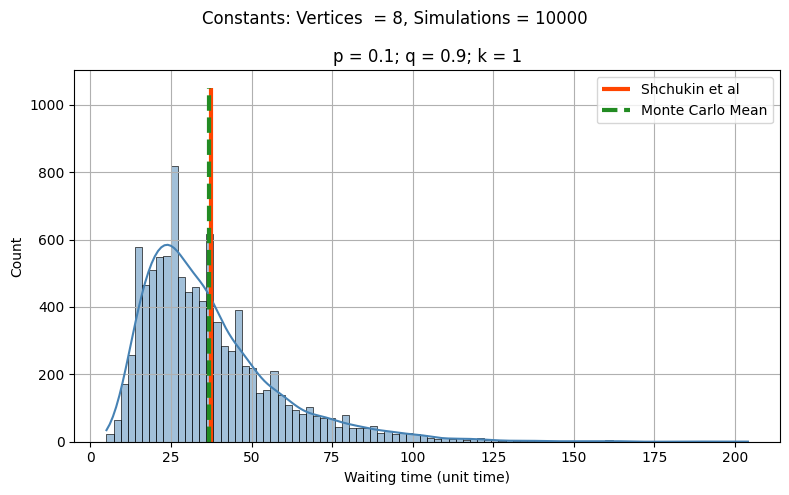

In [7]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.histplot(mc, ax = ax, kde = True, color = 'steelblue')
ax.vlines(shchukin_vals, 0, 1050, colors ='orangered', label = 'Shchukin et al', linewidth = 3)
ax.vlines(np.mean(mc), 0, 1050, colors='forestgreen', label = 'Monte Carlo Mean', linewidth = 3, linestyle = "dashed")
ax.set_xlabel("Waiting time (unit time)")
ax.set_ylabel("Count")
ax.set_title(f"p = {p}; q = {q}; k = {k}")
ax.legend(loc = 'best')
ax.grid(True)

plt.suptitle(f"Constants: Vertices  = {vertices}, Simulations = {sim_count}")

plt.tight_layout()

Clearly, we see that the Shchukin model and the Brand model (which we will now call the Markov Chain and the Monte-Carlo simulation), align well for the stated values of the number of segments.

##### Including Fusion

In our Markov Chain, we introduce the fusion vector $\Gamma$ which is multiplied to the full transition matrix as fusion occurs at the very end. We compute the Markov Chain and the Monte-Carlo simulation as before but for a non-ideal case of $k$. 

In [8]:
p = 0.1
q = 0.9
k = 0.3

mc = monte_carlo(vertices, sim_count, sim_count, p, q, k)
fusion_vals = including_fusion(vertices, p, q, k)

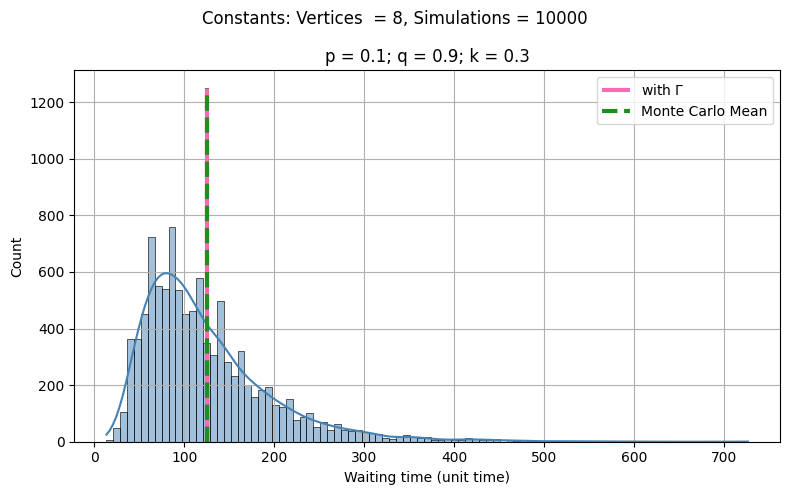

In [9]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.histplot(mc, ax = ax, kde = True, color = 'steelblue')
ax.vlines(fusion_vals, 0, 1250, colors ='hotpink', label = r'with $\Gamma$', linewidth = 3)
ax.vlines(np.mean(mc), 0, 1250, colors='forestgreen', label = 'Monte Carlo Mean', linewidth = 3, linestyle = "dashed")
ax.set_xlabel("Waiting time (unit time)")
ax.set_ylabel("Count")
ax.set_title(f"p = {p}; q = {q}; k = {k}")
ax.legend(loc = 'best')
ax.grid(True)


plt.suptitle(f"Constants: Vertices  = {vertices}, Simulations = {sim_count}")

plt.tight_layout()

##### Evaluating the time taken in classical communication and quantum operations

First we need to address the probabilistic nature of entanglement. From a recent paper on Nature, they generated ~ 99 x 10^3 pairs of entangled photons per second. Giving us the expected waiting time for a single entangled qubit generation to be 0.00001010101 seconds, and if we assume that the loss of the fiber can translate to whether the receiving node receives a qubit or not, we can model the time taken to generate entanglement by multiplying expected number of attempts required and the time required to generate a laser pulse.

Similarily, from another recent Nature paper, the time taken to perform a SWAP gate and the gate error have been noted; gate error of 0.0205 and gate time of 2.13e-6 seconds. They implement a ZZ gate with phase rotation of pi/2.

In [10]:
def p_l(L):
    return 10**((-0.2*L)/10)

q = 0.937708
k = 0.82452
c = 299792.458/1.4585 

def t_p(L):
    0.00001010101 + (L/c)

p_gen = 0.00001010101

t_q = 96.39e-6
t_k = 289.17e-6

In [11]:
max_ratios = []
min_ratios = []
mean_ratios = []
t_means = []
t_maxs = []
t_mins = []

distances = range(1, 100, 10)

for L in distances:
    p = p_l(L)

    _, this_np, this_nq, this_nk = monte_carlo(vertices, sim_count, sim_count, p, q, k, ind = True)

    this_np_max = max(this_np)
    this_np_mean = np.mean(this_np)
    this_np_min = min(this_np)
    this_nq_max = max(this_nq)
    this_nq_mean = np.mean(this_nq)
    this_nq_min = min(this_nq)
    this_nk_max = max(this_nk)
    this_nk_mean = np.mean(this_nk)
    this_nk_min = min(this_nk)


    t_classical_max = 2*vertices*this_np_max*(L/c) + 2*this_nq_max*(L/c)
    t_classical_min = 2*vertices*this_np_min*(L/c) + 2*this_nq_min*(L/c)
    t_classical_mean = 2*vertices*this_np_mean*(L/c) + 2*this_nq_mean*(L/c)

    t_quantum_max = this_np_max*p_gen+ this_nq_max*t_q + this_nk_max*t_k
    t_quantum_min = this_np_min*p_gen+ this_nq_min*t_q + this_nk_min*t_k
    t_quantum_mean = this_np_mean*p_gen+ this_nq_mean*t_q + this_nk_mean*t_k

    t_means.append(t_quantum_mean+t_classical_mean)
    t_maxs.append(t_quantum_max+t_classical_max)
    t_mins.append(t_quantum_min+t_classical_min)

    max_ratio_1 = t_classical_max + t_quantum_max
    max_ratios.append((t_classical_max/max_ratio_1, t_quantum_max/max_ratio_1))

    min_ratio_1 = t_classical_min + t_quantum_min
    min_ratios.append((t_classical_min/min_ratio_1, t_quantum_min/min_ratio_1))

    mean_ratio_1 = t_classical_mean + t_quantum_mean
    mean_ratios.append((t_classical_mean/mean_ratio_1,
                        (t_classical_mean/mean_ratio_1)*(this_np_mean/(this_np_mean+this_nq_mean)), #Time spent in instructing to (re)entangle
                        (t_classical_mean/mean_ratio_1)*(this_nq_mean/(this_np_mean+this_nq_mean)), #Time spent in instructing to (re)swap
                        (t_quantum_mean/mean_ratio_1)*(this_np_mean/(this_np_mean+this_nq_mean+this_nk_mean)),   #Time spent in entangling
                        (t_quantum_mean/mean_ratio_1)*(this_nq_mean/(this_np_mean+this_nq_mean+this_nk_mean)),   #Time spent in swapping
                        (t_quantum_mean/mean_ratio_1)*(this_nk_mean/(this_np_mean+this_nq_mean+this_nk_mean)),   #Time spent in fusion
                        t_quantum_mean/mean_ratio_1))


y_error = list(map(lambda x: (max_ratios[x][0] - min_ratios[x][0])/2, range(len(min_ratios))))

In [12]:
max_ratios_inset = []
min_ratios_inset = []
mean_ratios_inset = []
t_means_inset = []
t_max_inset = []
t_min_inset = []

distances_inset = range(1, 10)

for L in distances_inset:
    p = p_l(L)

    _, this_np, this_nq, this_nk = monte_carlo(vertices, sim_count, sim_count, p, q, k, ind = True)

    this_np_max = max(this_np)
    this_np_mean = np.mean(this_np)
    this_np_min = min(this_np)
    this_nq_max = max(this_nq)
    this_nq_mean = np.mean(this_nq)
    this_nq_min = min(this_nq)
    this_nk_max = max(this_nk)
    this_nk_mean = np.mean(this_nk)
    this_nk_min = min(this_nk)


    t_classical_max = 2*vertices*this_np_max*(L/c) + 2*this_nq_max*(L/c)
    t_classical_min = 2*vertices*this_np_min*(L/c) + 2*this_nq_min*(L/c)
    t_classical_mean = 2*vertices*this_np_mean*(L/c) + 2*this_nq_mean*(L/c)

    t_quantum_max = this_np_max*p_gen+ this_nq_max*t_q + this_nk_max*t_k
    t_quantum_min = this_np_min*p_gen+ this_nq_min*t_q + this_nk_min*t_k
    t_quantum_mean = this_np_mean*p_gen+ this_nq_mean*t_q + this_nk_mean*t_k

    t_means_inset.append(t_quantum_mean+t_classical_mean)
    t_max_inset.append(t_quantum_max+t_classical_max)
    t_min_inset.append(t_quantum_min+t_classical_min)

    max_ratio_1 = t_classical_max + t_quantum_max
    max_ratios_inset.append((t_classical_max/max_ratio_1, t_quantum_max/max_ratio_1))

    min_ratio_1 = t_classical_min + t_quantum_min
    min_ratios_inset.append((t_classical_min/min_ratio_1, t_quantum_min/min_ratio_1))

    mean_ratio_1 = t_classical_mean + t_quantum_mean
    mean_ratios_inset.append((t_classical_mean/mean_ratio_1,
                        (t_classical_mean/mean_ratio_1)*(this_np_mean/(this_np_mean+this_nq_mean)), #Time spent in instructing to (re)entangle
                        (t_classical_mean/mean_ratio_1)*(this_nq_mean/(this_np_mean+this_nq_mean)), #Time spent in instructing to (re)swap
                        (t_quantum_mean/mean_ratio_1)*(this_np_mean/(this_np_mean+this_nq_mean+this_nk_mean)),   #Time spent in entangling
                        (t_quantum_mean/mean_ratio_1)*(this_nq_mean/(this_np_mean+this_nq_mean+this_nk_mean)),   #Time spent in swapping
                        (t_quantum_mean/mean_ratio_1)*(this_nk_mean/(this_np_mean+this_nq_mean+this_nk_mean)),   #Time spent in fusion
                        t_quantum_mean/mean_ratio_1))



y_error_inset = list(map(lambda x: (max_ratios_inset[x][0] - min_ratios_inset[x][0])/2, range(len(min_ratios_inset))))

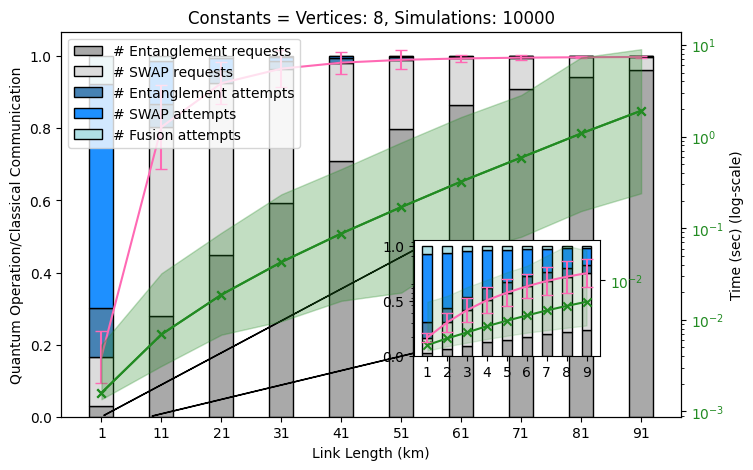

In [13]:
fig, ax = plt.subplots(figsize = (8, 5))
distances = range(1, 100, 10)

classical_tp_color = "darkgray"
classical_tq_color = "gainsboro"
quantum_tp_color = "steelblue"
quantum_tq_color = "dodgerblue"
quantum_tk_color = "powderblue"
t_color = "forestgreen"

bar_width = 4

for i, n in enumerate(mean_ratios[:-1]):
    ax.bar(distances[i], n[1], bottom = 0, width= bar_width, color = classical_tp_color, edgecolor = "black")
    ax.bar(distances[i], n[2], bottom = n[1], width= bar_width, color = classical_tq_color, edgecolor = "black")

    ax.bar(distances[i], n[3], bottom = n[2]+n[1], width= bar_width, color = quantum_tp_color, edgecolor = 'black')
    ax.bar(distances[i], n[4], bottom = n[3]+n[2]+n[1], width= bar_width, color = quantum_tq_color, edgecolor = "black")
    ax.bar(distances[i], n[5], bottom = n[4]+n[3]+n[2]+n[1], width= bar_width, color = quantum_tk_color, edgecolor = "black")


ax.bar(distances[-1], mean_ratios[-1][1], bottom = 0, width= bar_width, color = classical_tp_color, edgecolor = "black", label = "# Entanglement requests")
ax.bar(distances[-1], mean_ratios[-1][2], bottom = mean_ratios[-1][1], width= bar_width, color = classical_tq_color, edgecolor = "black", label = "# SWAP requests")
ax.bar(distances[-1], mean_ratios[-1][3], bottom = mean_ratios[-1][2]+mean_ratios[-1][1], width= bar_width, color = quantum_tp_color, edgecolor = 'black', label = "# Entanglement attempts")
ax.bar(distances[-1], mean_ratios[-1][4], bottom = mean_ratios[-1][3]+mean_ratios[-1][2]+mean_ratios[-1][1], width= bar_width, color = quantum_tq_color, edgecolor = "black", label = "# SWAP attempts")
ax.bar(distances[-1], mean_ratios[-1][5], bottom = mean_ratios[-1][4]+mean_ratios[-1][3]+mean_ratios[-1][2]+mean_ratios[-1][1], width= bar_width, color = quantum_tk_color, edgecolor = "black", label = "# Fusion attempts")


ax1 = ax.twinx()  

ax1.fill_between(distances, t_maxs, t_mins, alpha = 0.15, color = t_color)
ax1.scatter(distances, t_means, marker = 'x', color = t_color)
ax1.plot(distances, t_means, color = t_color)
ax1.set_yscale('log')

ax.set_xlabel('Link Length (km)')
ax.set_ylabel('Quantum Operation/Classical Communication')
ax1.set_ylabel('Time (sec) (log-scale)')


ax.errorbar(distances, list(map(lambda x: x[0], mean_ratios)), y_error, capsize= 4, color = "hotpink")
ax.set_xticks(np.arange(0, max(distances), 10)+1, distances)

ax1.tick_params(axis='y', labelcolor=t_color)

#inset plot
axins = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.58, 0.14, 0.3, 0.3),
                    bbox_transform=ax.transAxes, loc='lower right')

inset_width = 0.5

for i, n in enumerate(mean_ratios_inset[:-1]):
    axins.bar(distances_inset[i], n[1], bottom = 0, width= inset_width, color = classical_tp_color, edgecolor = "black")
    axins.bar(distances_inset[i], n[2], bottom = n[1], width= inset_width, color = classical_tq_color, edgecolor = "black")

    axins.bar(distances_inset[i], n[3], bottom = n[2]+n[1], width= inset_width, color = quantum_tp_color, edgecolor = 'black')
    axins.bar(distances_inset[i], n[4], bottom = n[3]+n[2]+n[1], width= inset_width, color = quantum_tq_color, edgecolor = "black")
    axins.bar(distances_inset[i], n[5], bottom = n[4]+n[3]+n[2]+n[1], width= inset_width, color = quantum_tk_color, edgecolor = "black")



axins.bar(distances_inset[-1], mean_ratios_inset[-1][1], bottom = 0, width= inset_width, color = classical_tp_color, edgecolor = "black")
axins.bar(distances_inset[-1], mean_ratios_inset[-1][2], bottom = mean_ratios_inset[-1][1], width= inset_width, color = classical_tq_color, edgecolor = "black")
axins.bar(distances_inset[-1], mean_ratios_inset[-1][3], bottom = mean_ratios_inset[-1][2]+mean_ratios_inset[-1][1], width= inset_width, color = quantum_tp_color, edgecolor = 'black')
axins.bar(distances_inset[-1], mean_ratios_inset[-1][4], bottom = mean_ratios_inset[-1][3]+mean_ratios_inset[-1][2]+mean_ratios_inset[-1][1], width= inset_width, color = quantum_tq_color, edgecolor = "black")
axins.bar(distances_inset[-1], mean_ratios_inset[-1][5], bottom = mean_ratios_inset[-1][4]+mean_ratios_inset[-1][3]+mean_ratios_inset[-1][2]+mean_ratios_inset[-1][1], width= inset_width, color = quantum_tk_color, edgecolor = "black")

ax1_ins = axins.twinx()

ax1_ins.fill_between(distances_inset, t_max_inset, t_min_inset, alpha = 0.15, color = t_color)
ax1_ins.scatter(distances_inset, t_means_inset, marker = 'x', color = t_color)
ax1_ins.plot(distances_inset, t_means_inset, color = t_color)

axins.errorbar(distances_inset, list(map(lambda x: x[0], mean_ratios_inset)), y_error_inset, capsize= 4, color = "hotpink")
axins.set_xticks(np.arange(0, max(distances_inset))+1, distances_inset)

ax1_ins.tick_params(axis='y', labelcolor=t_color)

ax1_ins.set_yscale('log')

import matplotlib.patches as mpatches

x_tail = 54
y_tail = 0.47
x_head = 1
y_head = 0
dx = x_head - x_tail
dy = y_head - y_tail

arrow_1 = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 mutation_scale=1)
ax.add_patch(arrow_1)


x_tail = 54
y_tail = 0.18
x_head = 9
y_head = 0
dx = x_head - x_tail
dy = y_head - y_tail

arrow_2 = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 mutation_scale=1)
ax.add_patch(arrow_2)

ax.set_title(f"Constants = Vertices: {vertices}, Simulations: {sim_count}")
ax.legend(loc = 'upper left')

ax1.fill_between(distances, t_maxs, t_mins, alpha = 0.15, color = t_color)
ax1.scatter(distances, t_means, marker = 'x', color = t_color)
ax1.plot(distances, t_means, color = t_color)
ax1.set_yscale('log')